In [114]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [115]:
date = '20220703'
dataNo = 1
scanNo = 1

In [116]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [117]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

Text(0.5, 1.0, 'The number of images = 2638')

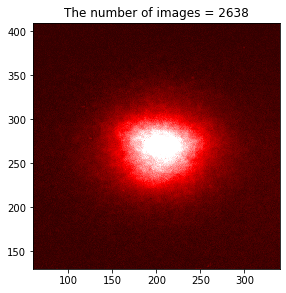

In [118]:
vmin = 0
vmax = 200
xlim_1 = 60
xlim_2 = 340
ylim_1 = 130
ylim_2 = 410

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(img_trans_list)))

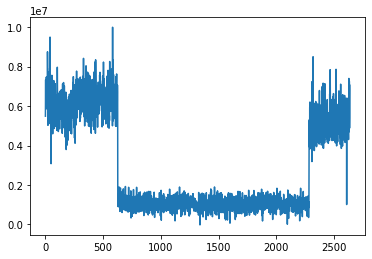

In [119]:
flCount = scan_data['Total count1 @ ROI1 (arb. u.)']
plt.plot(flCount)

In [120]:
postSelected_trans_files = []
postSelected_img_trans_list = []
threshold = 4e06

for i in range(len(trans_files)):
    if flCount[i] > threshold:
        postSelected_trans_files.append(trans_files[i])
        postSelected_img_trans_list.append(img_trans_list[i])

postSelected_img_trans_ave =np.average(postSelected_img_trans_list,axis=0)

Text(0.5, 1.0, 'The number of images = 966')

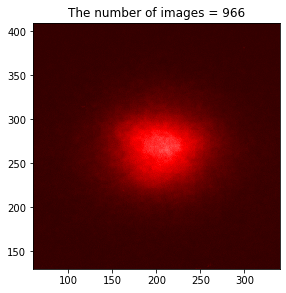

In [121]:
vmin = 0
vmax = 1000
xlim_1 = 60
xlim_2 = 340
ylim_1 = 130
ylim_2 = 410

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(postSelected_img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(postSelected_img_trans_list)))

In [122]:
cx = 200
cy = 270
wx = 10
wy = 10
momentum_peaks_C1_dx_list = [30, -31, 8]
momentum_peaks_C1_dy_list = [-20, -9, 31]
momentum_peaks_C2_dx_list = [-7, 35, -27]
momentum_peaks_C2_dy_list = [-29, 12, 24]

# momentum_peaks_C1_dx_list = [60, -62, 17]
# momentum_peaks_C1_dy_list = [-40, -17, 62]
# momentum_peaks_C2_dx_list = [-13, 69, -53]
# momentum_peaks_C2_dy_list = [-57, 24, 47]

shift_dx_list = []
shift_dy_list = []
list(map(lambda x: shift_dx_list.extend(x), ([0],momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list)))
list(map(lambda x: shift_dy_list.extend(x), ([0],momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list)))

subROI_parameters_list = []

def createSubROI(mainROI_cx, mainROI_cy, wx, wy, shift_dx=0, shift_dy=0):
    subROI_x0 = mainROI_cx + shift_dx - wx
    subROI_x1 = mainROI_cx + shift_dx + wx
    subROI_y0 = mainROI_cy + shift_dy - wy
    subROI_y1 = mainROI_cy + shift_dy + wy
    subROI_xmesh, subROI_ymesh = np.meshgrid(np.arange(subROI_x0,subROI_x1), np.arange(subROI_y0,subROI_y1))
    return subROI_xmesh, subROI_ymesh, subROI_x0, subROI_x1, subROI_y0, subROI_y1

for i in range(len(shift_dx_list)):
    subROI_parameters_temp = createSubROI(cx,cy, wx, wy, shift_dx_list[i], shift_dy_list[i])
    subROI_parameters_list.append(subROI_parameters_temp)

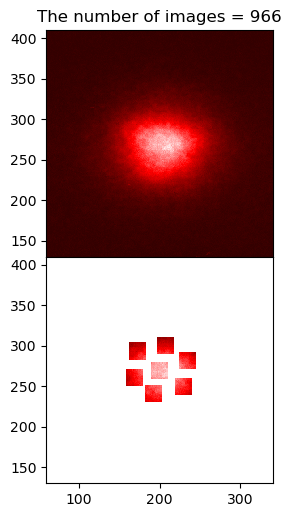

In [123]:
vmin = 0
vmax = 700
# xlim_1 = 120
# xlim_2 = 360
# ylim_1 = 130
# ylim_2 = 370

sampleImages_list = [postSelected_img_trans_ave]
sample_list = [0]
fig, axs = plt.subplots(ncols=len(sampleImages_list), nrows=2, figsize=[6, 6], dpi=100, sharex=True, sharey=True)
axs = np.reshape(axs, [-1, ])
for i in range(len(sampleImages_list)*2):
    if i<len(sampleImages_list):
        axs[i].pcolormesh(sampleImages_list[i], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
        axs[i].set_title("The number of images = %.d"%(len(postSelected_img_trans_list)))
    else:
        for j in range(len(shift_dx_list)):
            axs[i].pcolormesh(subROI_parameters_list[j][0],subROI_parameters_list[j][1],sampleImages_list[i-len(sampleImages_list)][subROI_parameters_list[j][4]:subROI_parameters_list[j][5],subROI_parameters_list[j][2]:subROI_parameters_list[j][3]], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(xlim_1,xlim_2)
    axs[i].set_ylim(ylim_1,ylim_2)
fig.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [124]:
center_list = []
side1_list = []
side2_list = []
visibility_list = []

for j in range(len(postSelected_trans_files)):
    center_list.append(np.sum(postSelected_img_trans_list[j][subROI_parameters_list[0][4]:subROI_parameters_list[0][5],subROI_parameters_list[0][2]:subROI_parameters_list[0][3]])/np.sum(postSelected_img_trans_list[j]))
    side1_list.append(np.sum(list(map(lambda x: postSelected_img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(1,3,1))))/np.sum(postSelected_img_trans_list[j]))
    side2_list.append(np.sum(list(map(lambda x: postSelected_img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(3,5,1))))/np.sum(postSelected_img_trans_list[j]))
    visibility_list.append((side1_list[-1]-side2_list[-1])/(side1_list[-1]+side2_list[-1]))

x_list = np.arange(0,len(postSelected_trans_files),1)

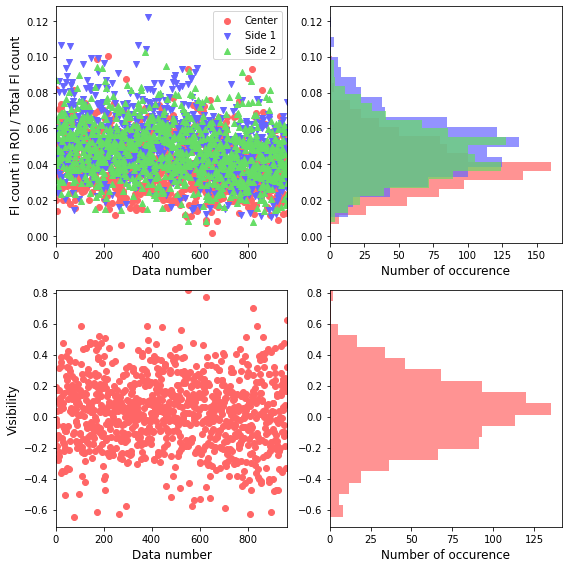

In [125]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(x_list,center_list,  marker='o', c='#ff6666',label='Center')
ax1.scatter(x_list, side1_list, marker='v',c='#6666ff',label='Side 1')
ax1.scatter(x_list, side2_list, marker='^',c='#66dd66',label='Side 2')
ax1.set_xlabel(r'Data number',fontsize=12)
ax1.set_ylabel('Fl count in ROI / Total Fl count',fontsize=12)
ax1.set_xlim(0,len(postSelected_trans_files))
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(np.array(center_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
ax2.hist(np.array(side1_list),bins=20,color='#6666ff', alpha=0.7,orientation='horizontal')
ax2.hist(np.array(side2_list),bins=20,color='#66dd66', alpha=0.7,orientation='horizontal')
# ax2.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax2.set_xlabel('Number of occurence',fontsize=12)


ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(postSelected_trans_files))
ax3.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
ax4.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax4.set_xlabel('Number of occurence',fontsize=12)

plt.tight_layout()

In [132]:
threshold = -0.4

post_selected_images_1 = []

for i in range(len(postSelected_trans_files)):
    if visibility_list[i] < threshold:
        post_selected_images_1.append(postSelected_img_trans_list[i])

post_selected_images_1_ave = np.average(post_selected_images_1,axis=0)

Text(0.5, 1.0, 'OD1')

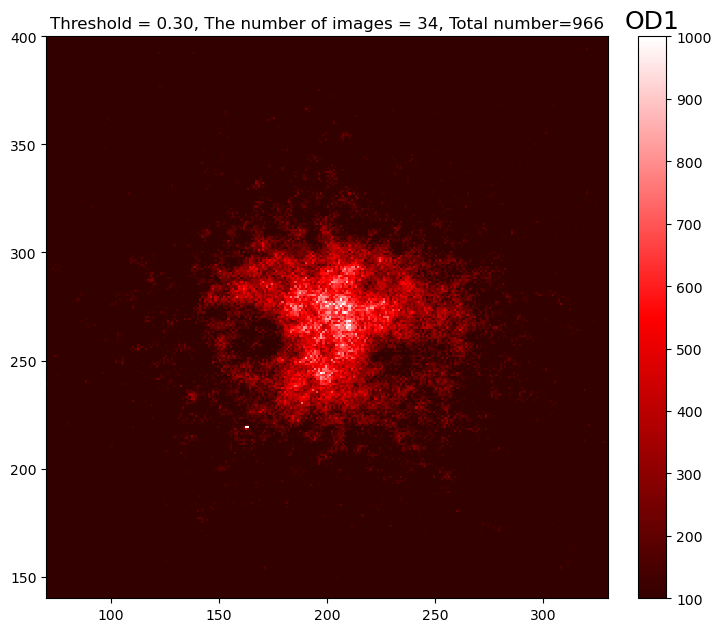

In [140]:
vmin = 100
vmax = 1000
xlim_1 = 70
xlim_2 = 330
ylim_1 = 140
ylim_2 = 400

fig =plt.figure(figsize=[8,8],dpi=100)
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(post_selected_images_1_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.02f, The number of images = %d, Total number=%d"%(threshold, len(post_selected_images_1), len(postSelected_img_trans_list)))
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.3)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"OD1", fontsize=18)

In [141]:
threshold = 0.3

post_selected_images_2 = []

for i in range(len(postSelected_trans_files)):
    if visibility_list[i] > threshold:
        post_selected_images_2.append(postSelected_img_trans_list[i])

post_selected_images_2_ave = np.average(post_selected_images_2,axis=0)

Text(0.5, 1.0, 'OD2')

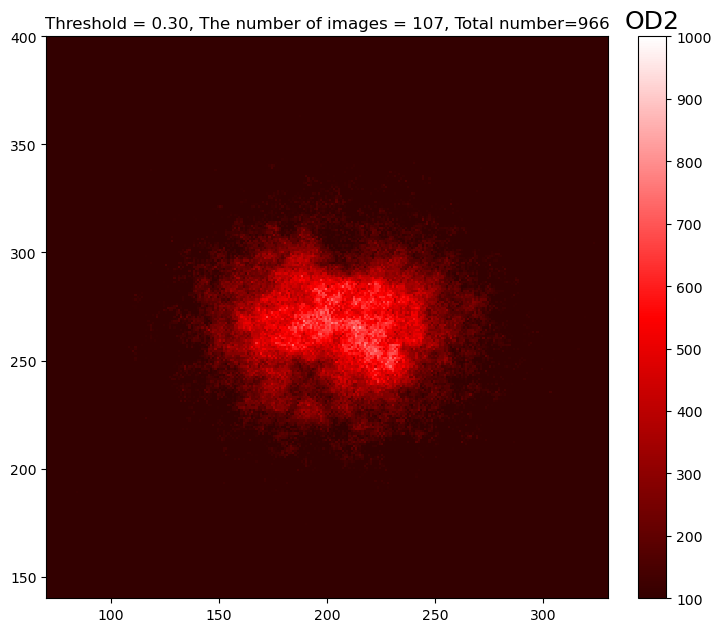

In [142]:
vmin = 100
vmax = 1000
xlim_1 = 70
xlim_2 = 330
ylim_1 = 140
ylim_2 = 400

fig =plt.figure(figsize=[8,8],dpi=100)
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(post_selected_images_2_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.02f, The number of images = %d, Total number=%d"%(threshold, len(post_selected_images_2), len(postSelected_img_trans_list)))
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.3)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"OD2", fontsize=18)

Text(0.5, 1.0, 'OD1 - OD2')

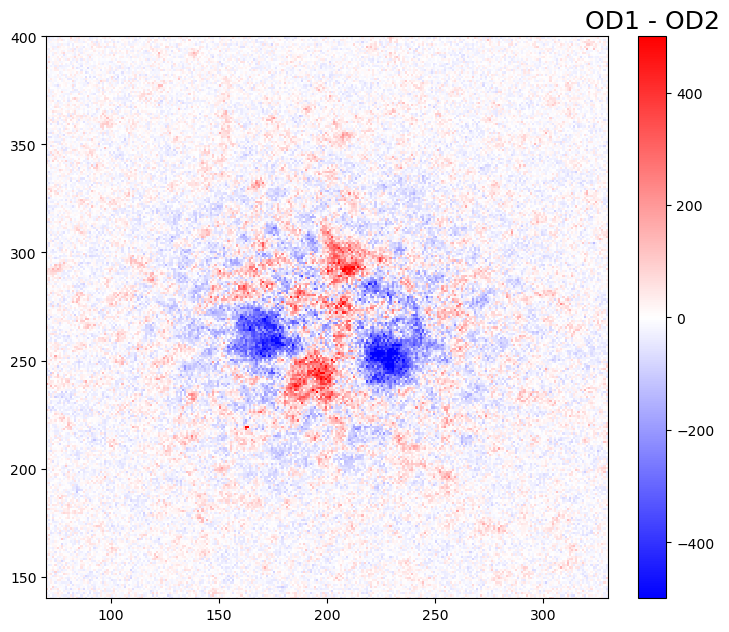

In [143]:
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-500, vmax=500 )
xlim_1 = 70
xlim_2 = 330
ylim_1 = 140
ylim_2 = 400

fig =plt.figure(figsize=[8,8],dpi=100)
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(post_selected_images_1_ave -post_selected_images_2_ave,cmap='bwr', norm=norm, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.3)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"OD1 - OD2", fontsize=18)
